In [148]:
import numpy as np
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)
np.set_printoptions(precision=3)
from scipy.special import expit as invlogit
import warnings
warnings.filterwarnings("ignore")

In [2]:
A = pd.read_csv('GambleA.txt','\t', header=None, names = ['v1','p1','v2','p2'])
B = pd.read_csv('GambleB.txt','\t', header=None, names = ['v1','p1','v2','p2'])
Choices  = pd.read_csv('Rieskamp_data.txt','\t', header=None)

In [3]:
def reorder(row = None):
    """
    To fullfill conditions for prospect theory
    ======
    Pure gain case (binary choice problem, only case when p+q=1):
    0<x<y
    (1-w(q))v(x)+w(q)v(y)
    =====
    Pure loss case (binary choice problem, only case when p+q=1):
    y<x<0
    (1-w(q))v(x)+w(q)v(y)
    
    """
    
    x,p,y,q = row
    if (((x>0)&(y>0))&(x > y)) | (((x<0) & (y<0))&(y > x)) :
        x,y = y,x
        p,q = q,p
        
    return x,p,y,q

def reorder_array(df = None):
    new_df = df.apply(reorder,axis=1, result_type = 'expand')
    new_df.columns = ['x','p','y','q']
    return new_df

In [4]:
npA, npB = reorder_array(A).values, reorder_array(B).values
fullA = np.repeat(npA,30, axis=0)
fullB = np.repeat(npB,30, axis=0)

## Data preprocessing step
transform our data next way:
each option for each individual and concatenate with the choice.
First 1800 rows  - pure gain
From 1801 to 3600  - pure loss
From 3601 to 5400  - mixed type

In [5]:
df = pd.DataFrame(np.concatenate([fullA,fullB,Choices.values.reshape(-1,1),np.tile(np.arange(30),180).reshape(-1,1)], axis=1), 
             columns=['xA','pA','yA','qA','xB','pB','yB','qB','Chs','PId'])
df.PId=df.PId.astype('int')
df['GameId'] = np.repeat(range(180),30, axis=0)
df['GameType'] = 0
df.loc[1800:3600,'GameType'] = 1
df.loc[3601:,'GameType'] = 2
df.head(10)

,xA,pA,yA,qA,xB,pB,yB,qB,Chs,PId,GameId,GameType
0,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,1.0,0,0,0
1,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,0.0,1,0,0
2,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,0.0,2,0,0
3,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,1.0,3,0,0
4,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,0.0,4,0,0
5,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,1.0,5,0,0
6,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,1.0,6,0,0
7,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,0.0,7,0,0
8,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,0.0,8,0,0
9,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,1.0,9,0,0


Select only pure game type.
We will work only with the pure game type

In [6]:
df = df.iloc[:3600]

# Cumulative prospect theory


$$V(A) = \sum v(x_i)*\omega(p_i)$$

where $V(A)$ - value function, $\omega(p_i)$ - decision weights for for gains and losses


$$ v(x_i) = \begin{cases} 
    	x^{\alpha}, 
    	& \text{if}\, (x)>0 \\
    	-\lambda (-x)^{\alpha}, & \text{else}
    \end{cases}$$
$$ \omega(p) = \frac{p^{\gamma_{ind}}}{(p^{\gamma_{ind}} + (1-p)^{\gamma_{ind}})^1/\gamma_{ind}} $$
where $ind = +,\text{ if positive }, - \text{ else }$


Choice function:

$$\theta  = \frac{1}{1+e^{-\phi(V(B)-V(A))}}$$

Here binary options games. Add the description....

### Theano functions for pyMC3

In [7]:
def weights(p,c):
    """
    one-parameter weighting function used in Nilsson
    
    
    @param p: float, real probability of gain or loss, should be in the interval (0,1) 
    @param c: float,the elevation of the weighting function, should be positive, expected in the interval (0,5) 
    
    @return: float, subjective probability of gain or loss, should be in the interval (0,1) 
    """
    numer = tt.pow(p,c)
    denom = tt.pow(tt.pow(p,c) + tt.pow(1-p,c),1/c)
    return numer/denom


def value_f(x, alpha):
    """
    the power value function suggested by Tversky and Kahneman (1992)
    @param x: float, positive, money
    @param alpha: float, expected to be less then 1     
    """
    return tt.sgn(x)*tt.pow(tt.abs_(x),alpha)


def value_pure(x, p, y, q, alpha,c):
    
    w_q = weights(q,c)
    val = (1 - w_q)*value_f(x, alpha) + w_q*value_f(y, alpha)
    return val

    
def probit(x):
    mu = 0
    sd = 1
    return 0.5*(1+tt.erf((x-mu)/(sd*tt.sqrt(2))))    

## EDA
by each game pair Gap = B-A, if B>A than we will choose B, so in Choices we have 1 if B better then A

In [8]:
alpha = np.array([0.87,0.98])
c = np.array([0.71,0.82])
valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[df.GameType.values], c[df.GameType.values]).eval()
valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[df.GameType.values], c[df.GameType.values]).eval()
df['nGap'] = valB-valA

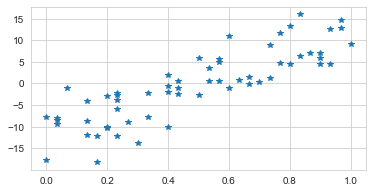

In [9]:
res = df.groupby('GameId')[['nGap','Chs']].mean()
plt.plot(res.Chs[:60], res.nGap[:60],'*')

## Model in pyMC

Function for checking posterior

In [153]:
def est_model_group(trace, model, df=None):
    est_df = df.copy()
    #alpha = trace['alpha'].mean(axis=0)
    #c = trace['c'].mean(axis=0)
    #valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[df.GameType.values], c[df.GameType.values]).eval()
    #valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[df.GameType.values], c[df.GameType.values]).eval()
    #est_df['estGap'] = valB-valA
    ppc = pm.sample_posterior_predictive(trace, samples=30, model=model)
    beta = st.beta((ppc['Strg'] == 1).sum(axis=0), (ppc['Strg'] == 0).sum(axis=0))
    est_df['Pred_lb'] = beta.interval(0.95)[0]
    est_df['Pred_ub'] = beta.interval(0.95)[1]
    est_df['Pred'] = ppc['Strg'].mean(axis=0)
    res = est_df.groupby('GameId')[['Pred','Chs', 'Pred_lb', 'Pred_ub']].mean()
    errs = (res['Pred_lb'].values.T,res['Pred_ub'].values.T)

    plt.plot(res.Chs, res.Pred,'*',[0,1],[0,1]);
    plt.vlines(res.Chs, *errs, colors='gray')
    
    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(res.Chs.values.reshape(-1,1), res.Pred.values.reshape(-1,1))
    print(f'R^2 value for real and predicted data: {regressor.score(res.Chs.values.reshape(-1,1), res.Pred.values.reshape(-1,1)):.2f}')

    #plt.show()
    return est_df

def post_check(model, trace, df=None, varnames = ['~theta']):
    print('Log-likelihood:  ', az.waic(trace))
    print(az.summary(trace, var_names = varnames, kind = 'stats'))
    est_df = est_model_group(trace, model, df)
    az.plot_trace(trace, var_names = varnames);
    return est_df

## Model 1: model without any individual differences (Uniform priors)


In [11]:
n_chains = 4

with pm.Model() as model_1:
    alpha = pm.Uniform('alpha', lower=0.4, upper=0.99, shape = 2)
    c = pm.Uniform('c', lower=0.4, upper=0.9, shape = 2)
    phi = pm.Uniform('phi', lower=0.1, upper=0.5, shape = 2)
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[df.GameType.values], c[df.GameType.values])
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[df.GameType.values], c[df.GameType.values])
    gap  = valB - valA
    theta = pm.math.invlogit(phi[df.GameType.values] * gap)
    theta = pm.Deterministic('theta', theta)
    #pm.Deterministic('gap', gap)
    strategy = pm.Bernoulli("Strg", p=theta, observed=df.Chs.values)
    trace_1 = pm.sample(2000, tune=500, target_accept = 0.95, chains=n_chains)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, c, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [02:13<00:00, 74.79draws/s]
The number of effective samples is smaller than 25% for some parameters.


100%|██████████| 30/30 [00:00<00:00, 433.92it/s]


R^2 value for real and predicted data: 0.78


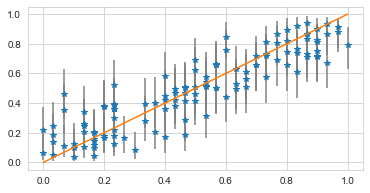

In [154]:
est_df = est_model_group(trace_1, model_1, df)

Log-likelihood:   Computed from 8000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1978.29    29.00
p_waic        4.84        -


  0%|          | 1/500 [00:00<01:06,  7.54it/s]

           mean     sd  hpd_3%  hpd_97%
alpha[0]  0.686  0.035   0.634    0.756
alpha[1]  0.962  0.025   0.914    0.990
c[0]      0.795  0.039   0.722    0.868
c[1]      0.786  0.033   0.723    0.847
phi[0]    0.405  0.065   0.289    0.500
phi[1]    0.125  0.017   0.100    0.156


100%|██████████| 500/500 [00:01<00:00, 492.64it/s]


R^2 value for real and predicted data: 0.77


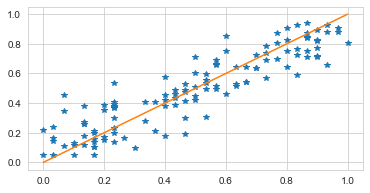

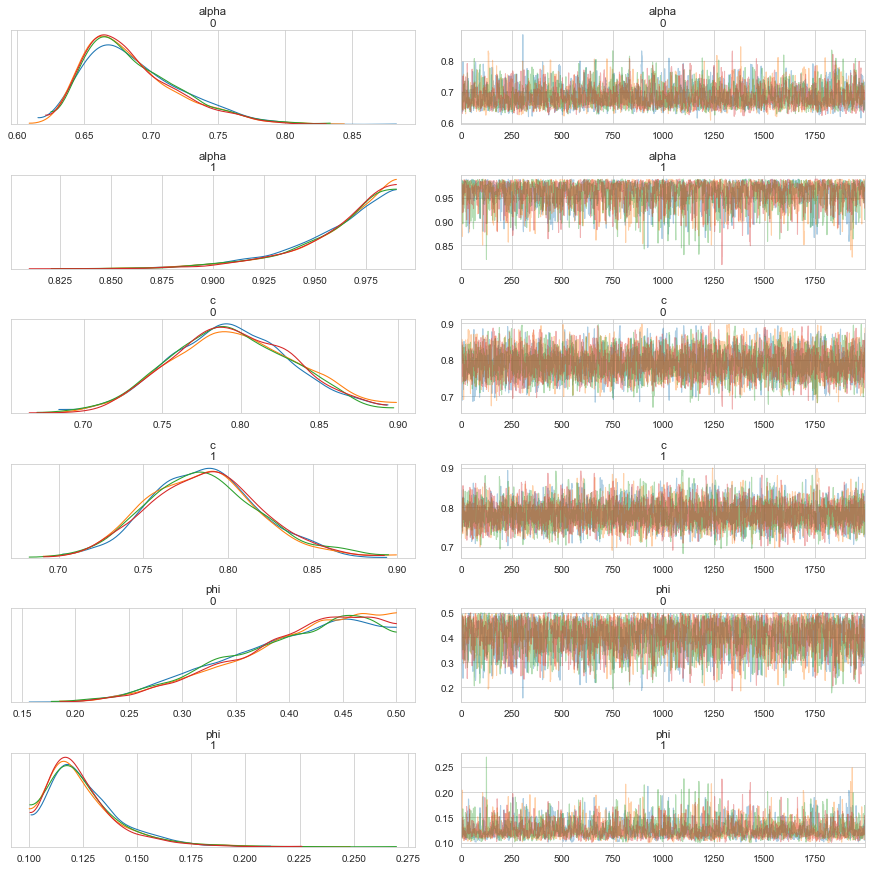

In [12]:
post_check(model_1, trace_1, df)    

## Model 2: model without any individual differences (Normal priors)

In [13]:
n_chains = 4

with pm.Model() as model_2:
        
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = BoundedNormalI('alpha', mu=0.8, sd=0.5, shape = 2)
    c = BoundedNormalI('c', mu=0.7, sd=0.5, shape = 2)
    phi = BoundedNormal('phi', mu=0.2, sd=0.5, shape = 2)
    
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[df.GameType.values], c[df.GameType.values])
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[df.GameType.values], c[df.GameType.values])
    gap  = valB - valA
    theta = pm.math.invlogit(phi[df.GameType.values] * gap)
    theta = pm.Deterministic('theta', theta)
    #pm.Deterministic('gap', gap)
    strategy = pm.Bernoulli("Strg", p=theta, observed=df.Chs.values)
    trace_2 = pm.sample(2000, tune=500, target_accept = 0.95, chains=n_chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, c, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [02:49<00:00, 58.91draws/s]


100%|██████████| 30/30 [00:00<00:00, 443.09it/s]


R^2 value for real and predicted data: 0.77


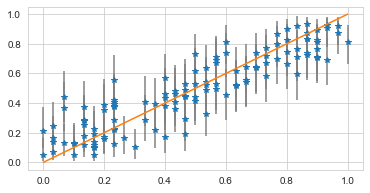

In [155]:
est_df = est_model_group(trace_2, model_2, df)

Log-likelihood:   Computed from 8000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1978.48    29.06
p_waic        5.48        -


  0%|          | 1/500 [00:00<00:55,  8.91it/s]

           mean     sd  hpd_3%  hpd_97%
alpha[0]  0.650  0.054   0.552    0.753
alpha[1]  0.970  0.027   0.920    1.000
c[0]      0.811  0.046   0.730    0.900
c[1]      0.785  0.031   0.731    0.850
phi[0]    0.501  0.138   0.257    0.762
phi[1]    0.121  0.017   0.096    0.154


100%|██████████| 500/500 [00:01<00:00, 495.88it/s]


R^2 value for real and predicted data: 0.78


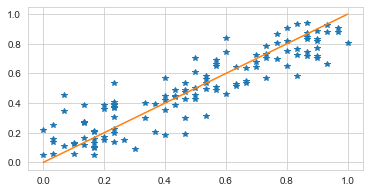

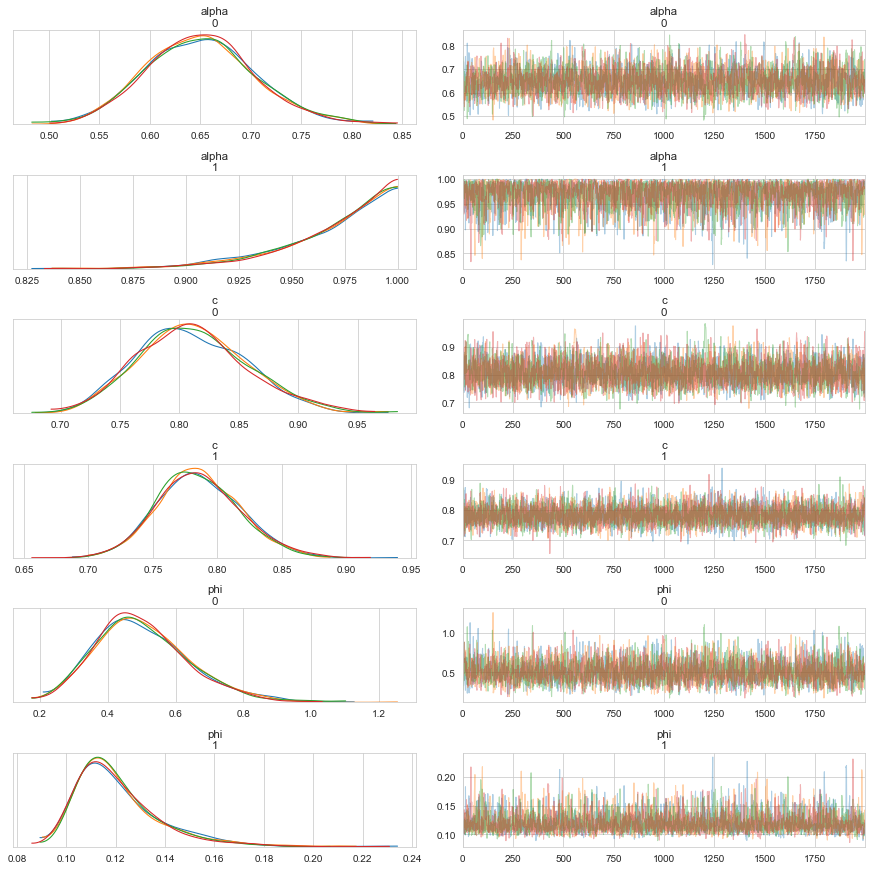

In [14]:
post_check(model_2, trace_2, df)    

### Model 3  - group-level with probit transform


In [15]:
with pm.Model() as model_3:
        
    
    alpha_t = pm.Normal('alpha_t', mu=0, sd=5, shape = 2)
    alpha = pm.Deterministic('alpha',probit(alpha_t))
    c_t = pm.Normal('c_t', mu=0, sd=5, shape = 2)
    c = pm.Deterministic('c',probit(c_t))
    phi = pm.Uniform('phi', lower=0.1, upper=0.5, shape = 2)
    
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[df.GameType.values], c[df.GameType.values])
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[df.GameType.values], c[df.GameType.values])
    gap  = valB - valA
    theta = pm.math.invlogit(phi[df.GameType.values] * gap)
    theta = pm.Deterministic('theta', theta)
    #pm.Deterministic('gap', gap)
    strategy = pm.Bernoulli("Strg", p=theta, observed=df.Chs.values)
    trace_3 = pm.sample(2000, tune=500, target_accept = 0.95, chains=n_chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, c_t, alpha_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [03:41<00:00, 45.13draws/s]
The number of effective samples is smaller than 25% for some parameters.


100%|██████████| 30/30 [00:00<00:00, 408.29it/s]


R^2 value for real and predicted data: 0.78


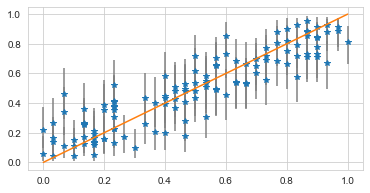

In [156]:
est_df = est_model_group(trace_3, model_3, df)

Log-likelihood:   Computed from 8000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1977.16    29.20
p_waic        4.72        -


  0%|          | 1/500 [00:00<01:07,  7.42it/s]

           mean     sd  hpd_3%  hpd_97%
alpha[0]  0.687  0.037   0.630    0.756
alpha[1]  0.997  0.009   0.982    1.000
c[0]      0.803  0.047   0.722    0.893
c[1]      0.781  0.032   0.726    0.845
phi[0]    0.403  0.067   0.286    0.500
phi[1]    0.108  0.006   0.100    0.117


100%|██████████| 500/500 [00:01<00:00, 482.59it/s]


R^2 value for real and predicted data: 0.78


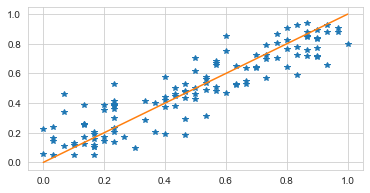

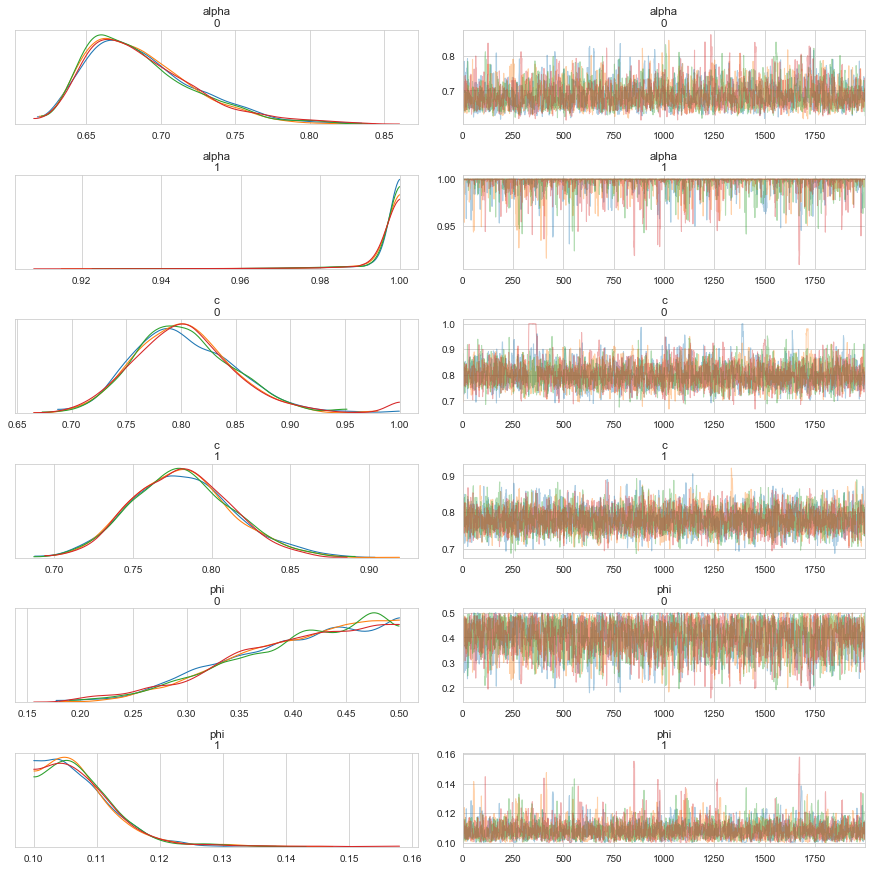

In [16]:
post_check(model_3, trace_3, df, varnames = ['alpha','c','phi'])    

### Model 4  - group-level Uniform with log transform
non-informative priors from Normal distribution, only group level

In [17]:
n_chains = 4

with pm.Model() as model_4:
    alpha = pm.Uniform('alpha', lower=0.4, upper=0.99, shape = 2)
    c = pm.Uniform('c', lower=0.4, upper=0.9, shape = 2)
    phi = pm.Uniform('phi', lower=0.1, upper=0.5, shape = 2)
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[df.GameType.values], c[df.GameType.values])
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[df.GameType.values], c[df.GameType.values])
    gap  = valB - valA
    gap = tt.sgn(gap)*tt.log(1+tt.abs_(gap))

    theta = pm.math.invlogit(phi[df.GameType.values] * gap)

    theta = pm.Deterministic('theta', theta)
    #pm.Deterministic('gap', gap)
    strategy = pm.Bernoulli("Strg", p=theta, observed=df.Chs.values)
    trace_4 = pm.sample(2000, tune=500, target_accept = 0.95, chains=n_chains)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, c, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:00<00:00, 165.25draws/s]


100%|██████████| 30/30 [00:00<00:00, 385.61it/s]


R^2 value for real and predicted data: 0.73


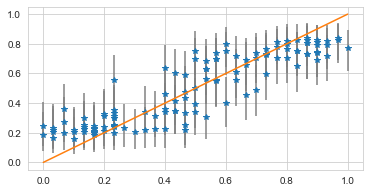

In [157]:
est_df = est_model_group(trace_4, model_4, df)

Log-likelihood:   Computed from 8000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1988.32    25.34
p_waic        4.31        -


  0%|          | 1/500 [00:00<01:03,  7.82it/s]

           mean     sd  hpd_3%  hpd_97%
alpha[0]  0.910  0.022   0.870    0.953
alpha[1]  0.978  0.011   0.958    0.990
c[0]      0.710  0.036   0.641    0.774
c[1]      0.788  0.032   0.727    0.847
phi[0]    0.492  0.008   0.478    0.500
phi[1]    0.487  0.011   0.467    0.500


100%|██████████| 500/500 [00:01<00:00, 444.63it/s]


R^2 value for real and predicted data: 0.72


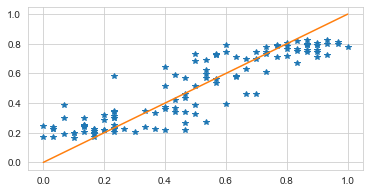

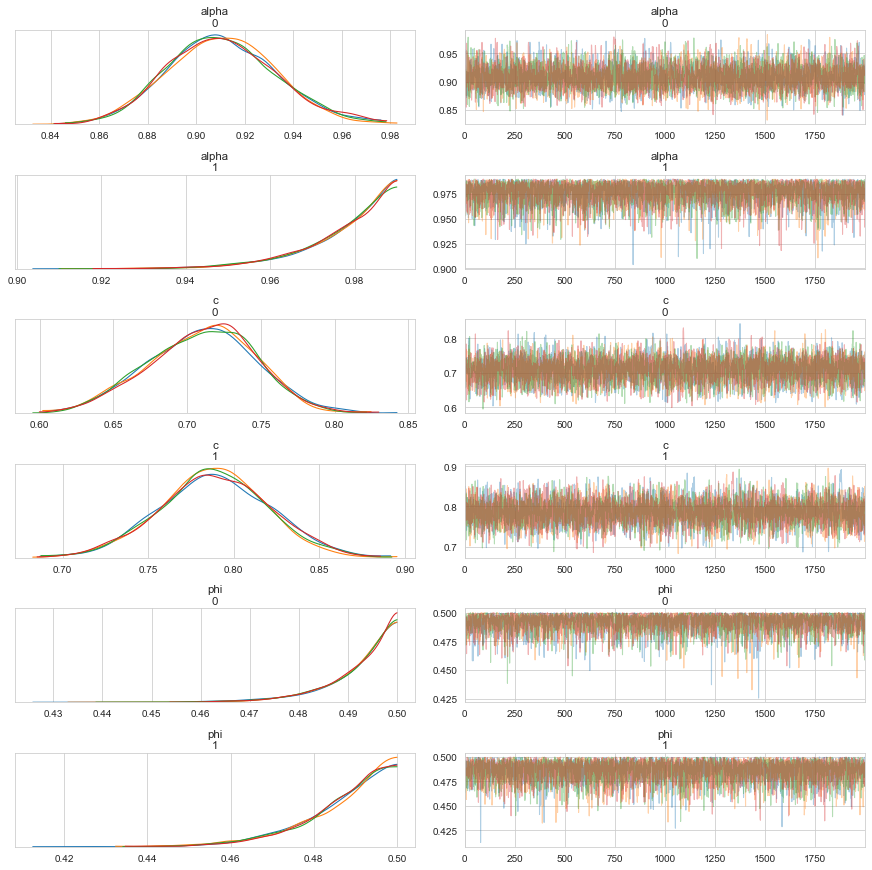

In [18]:
post_check(model_4, trace_4, df, varnames = ['alpha','c','phi'])    

## Model 5:  group-level Uniform with log transform and centered priors

In [19]:
n_chains = 4

with pm.Model() as model_5:
    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = BoundedNormalI('alpha', mu=0.8, sd=0.5, shape = 2)
    c = BoundedNormalI('c', mu=0.7, sd=0.5, shape = 2)
    phi = BoundedNormal('phi', mu=0.2, sd=0.5, shape = 2)
    
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[df.GameType.values], c[df.GameType.values])
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[df.GameType.values], c[df.GameType.values])
    gap  = valB - valA
    gap = tt.sgn(gap)*tt.log(1+tt.abs_(gap))

    theta = pm.math.invlogit(phi[df.GameType.values] * gap)

    theta = pm.Deterministic('theta', theta)
    #pm.Deterministic('gap', gap)
    strategy = pm.Bernoulli("Strg", p=theta, observed=df.Chs.values)
    trace_5 = pm.sample(2000, tune=500, target_accept = 0.95, chains=n_chains)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, c, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:56<00:00, 85.96draws/s]


100%|██████████| 30/30 [00:00<00:00, 378.08it/s]


R^2 value for real and predicted data: 0.79


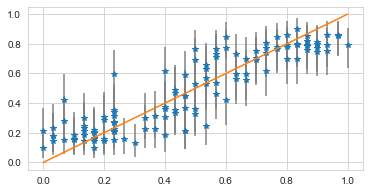

In [163]:
est_df = est_model_group(trace_5, model_5, df)

Log-likelihood:   Computed from 8000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1971.64    28.97
p_waic        5.89        -


  0%|          | 1/500 [00:00<01:03,  7.84it/s]

           mean     sd  hpd_3%  hpd_97%
alpha[0]  0.720  0.050   0.620    0.808
alpha[1]  0.952  0.043   0.870    1.000
c[0]      0.776  0.036   0.709    0.844
c[1]      0.789  0.031   0.730    0.846
phi[0]    0.926  0.126   0.698    1.160
phi[1]    0.559  0.054   0.474    0.664


100%|██████████| 500/500 [00:01<00:00, 425.21it/s]


R^2 value for real and predicted data: 0.79


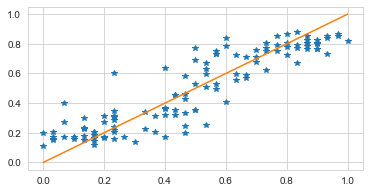

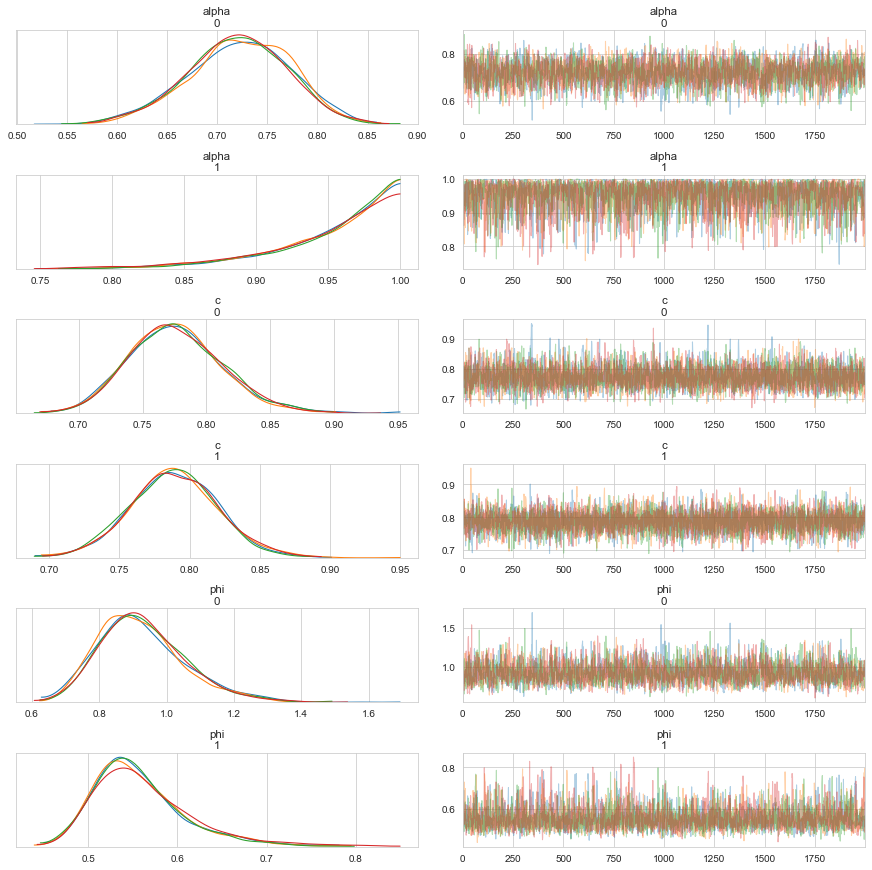

In [20]:
post_check(model_5, trace_5, df, varnames = ['alpha','c','phi'])    

## Model 6: group level (no group difference) but with the shared alpha

In [21]:
n_chains = 4

with pm.Model() as model_6:
    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = BoundedNormalI('alpha', mu=0.8, sd=0.5)
    c = BoundedNormalI('c', mu=0.7, sd=0.5, shape = 2)
    phi = BoundedNormal('phi', mu=0.2, sd=0.5, shape = 2)
    
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha, c[df.GameType.values])
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha, c[df.GameType.values])
    gap  = valB - valA
    #gap = tt.sgn(gap)*tt.log(1+tt.abs_(gap))

    theta = pm.math.invlogit(phi[df.GameType.values]* gap)

    theta = pm.Deterministic('theta', theta)
    #pm.Deterministic('gap', gap)
    strategy = pm.Bernoulli("Strg", p=theta, observed=df.Chs.values)
    trace_6 = pm.sample(2000, tune=500, target_accept = 0.95, chains=n_chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, c, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [03:00<00:00, 55.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


100%|██████████| 30/30 [00:00<00:00, 417.97it/s]


R^2 value for real and predicted data: 0.75


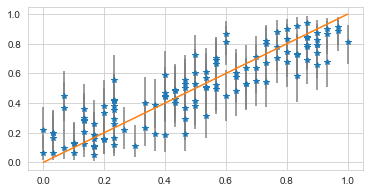

In [159]:
est_df = est_model_group(trace_6, model_6, df)

Log-likelihood:   Computed from 8000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1988.91    28.88
p_waic        5.78        -


  0%|          | 1/500 [00:00<00:55,  9.03it/s]

         mean     sd  hpd_3%  hpd_97%
alpha   0.866  0.051   0.768    0.959
c[0]    0.731  0.038   0.659    0.801
c[1]    0.807  0.036   0.739    0.874
phi[0]  0.168  0.044   0.089    0.248
phi[1]  0.197  0.047   0.112    0.279


100%|██████████| 500/500 [00:00<00:00, 501.71it/s]


R^2 value for real and predicted data: 0.76


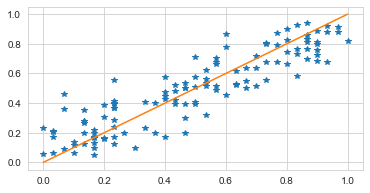

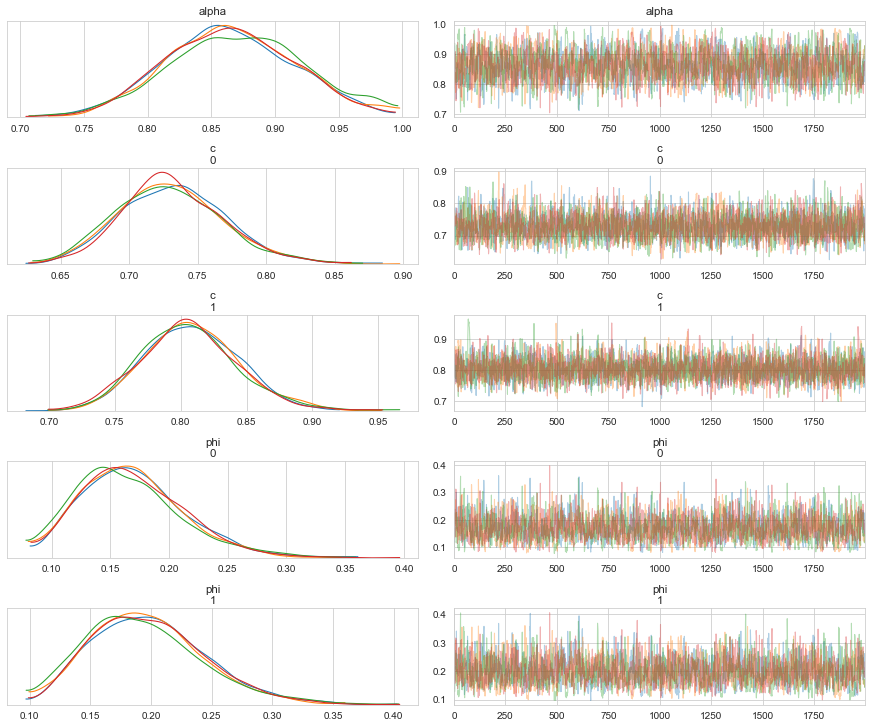

In [22]:
post_check(model_6, trace_6, df, varnames = ['alpha','c','phi'])    

## Models with the individual differences, hierarchical model

In [23]:
n_chains = 2

with pm.Model() as model_7:
    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    mu_alpha = BoundedNormalI('mu_alpha', mu=0.7, sd=0.3,shape = 2)
    std_alpha = pm.Uniform('std_alpha', 0.01,0.5, shape = 2)
    mu_c = BoundedNormalI('mu_c', mu=0.7, sd=0.3,shape = 2)
    std_c = pm.Uniform('std_c', 0.01,0.5, shape = 2)
    
    #alpha = BoundedNormalI('alpha', mu = tt.reshape(tt.tile(mu_alpha,30),(30,-1)), sd=std_alpha, shape = (30,2))
    alpha = BoundedNormalI('alpha', mu = mu_alpha, sd=std_alpha, shape = (30,2))
    c = BoundedNormalI('c',  mu_c, sd=std_c, shape = (30,2))
    
    mu_phi = BoundedNormal('mu_phi', mu=0.2, sd=0.5)
    std_phi = pm.Uniform('std_phi', 0.01,0.5)
    phi = BoundedNormal('phi', mu = mu_phi, sd=std_phi, shape = 30)
    
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[df.PId.values,df.GameType.values], c[df.PId.values,df.GameType.values])
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[df.PId.values,df.GameType.values], c[df.PId.values,df.GameType.values])
    gap  = valB - valA
    #gap = tt.sgn(gap)*tt.log(1+tt.abs_(gap))

    theta = pm.math.invlogit(phi[df.PId.values]* gap)

    theta = pm.Deterministic('theta', theta)
    #pm.Deterministic('gap', gap)
    strategy = pm.Bernoulli("Strg", p=theta, observed=df.Chs.values)
    trace_7 = pm.sample(500, tune=100, target_accept = 0.95, chains=n_chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phi, std_phi, mu_phi, c, alpha, std_c, mu_c, std_alpha, mu_alpha]
Sampling 2 chains, 1 divergences: 100%|██████████| 1200/1200 [23:23<00:00,  1.17s/draws]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6762406082062489, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Log-likelihood:   Computed from 1000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -3685.48   267.60
p_waic     1759.94        -

There has been a warning during the calculation. Please check the results.


  0%|          | 1/500 [00:00<00:54,  9.19it/s]

              mean     sd  hpd_3%  hpd_97%
mu_alpha[0]  0.766  0.076   0.694    0.879
mu_alpha[1]  0.581  0.285   0.297    0.907
mu_c[0]      0.630  0.109   0.524    0.781
mu_c[1]      0.660  0.133   0.528    0.830
mu_phi       1.278  1.029   0.200    2.305


100%|██████████| 500/500 [00:01<00:00, 470.92it/s]


R^2 value for real and predicted data: 0.80


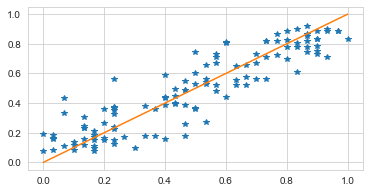

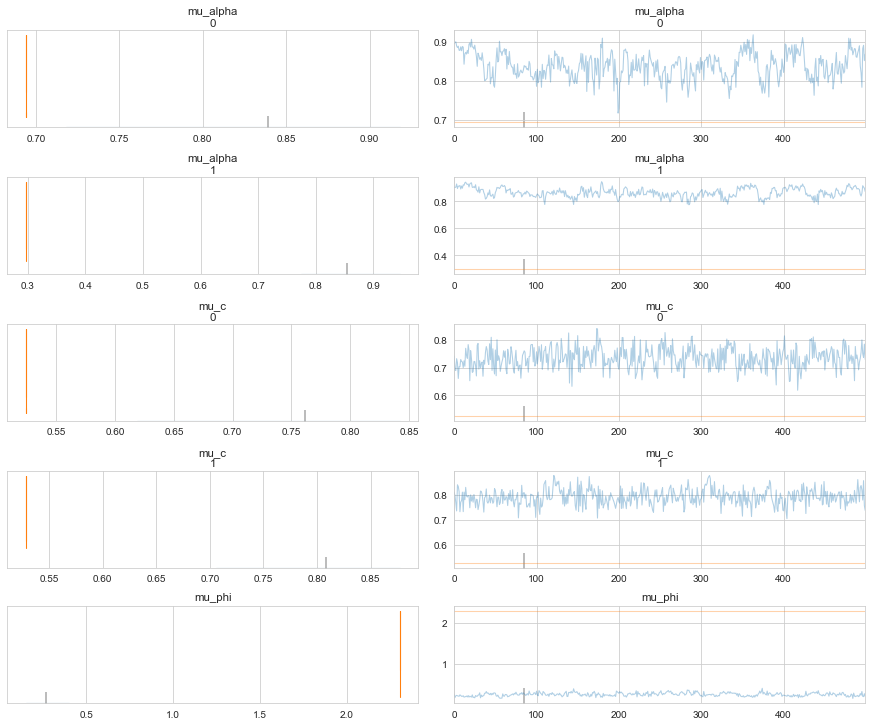

In [24]:
post_check(model_7, trace_7, df, varnames = ['mu_alpha','mu_c','mu_phi'])    

100%|██████████| 30/30 [00:00<00:00, 389.19it/s]


R^2 value for real and predicted data: 0.80


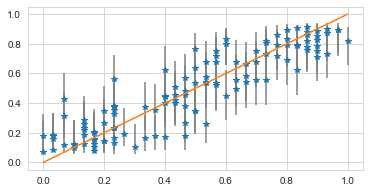

In [162]:
est_df = est_model_group(trace_7, model_7, df)